# World Cup 2018 Analysis
CMSC320 Final Project

By: Ethan Jew





With the World Cup just around the corner, I would like to see if there are any characteristics that are shared between teams that played in the 2018 World Cup. The characteristics that I will be looking at are some factors such as average age of the squads, how many appearances the players have, how many goals were scored, ..., and so on. The analysis that will be done will be between the teams that got eliminated in the group stage and the teams that made it to the round of 16. This analysis can be useful for predicting which teams will be more successful in this year's World Cup. While I am only analyzing the 2018 World Cup, there have been 20 other ones before this one. If there are patterns that are consistently seen across all these World Cups, then it could be a very useful predictor to see how far each team is going to make it into the tournament.

Some background on the World Cup, it's held every 4 years and is one of the most popular international sporting events. This comes to no surprise as football is one of the most popular sports in the world. Looking at the logistics of the World Cup, there are 32 teams and is divided into 2 phases: the group stages and single elimination stages (aka round of 16). Initially the 32 teams are put into groups of 4 for a total of 8 groups. Each team in the group plays each other. There is a point system where a win is 3 points, a draw is 1 point and a loss is 0 points. After all 6 games have been played, the top 2 teams with the most points will move onto the next round. If there is a tie between points then they will look at other factors such as goals scored, goals conceded (how many goals were let in), and so on (To find the official way to distinguish who will move on to the next round, here is an [article](https://www.eurosport.com/football/world-cup/2022/how-are-world-cup-2022-group-stages-decided-by-a-tie-breaker-is-it-goal-difference-or-head-to-head_sto9249634/story.shtml) that explains the rules). With the remaining 16 teams, they will play single elimination matches where the only difference now is that if there is a draw at the end of match time plus the added extra time, a penalty shoot-out will be used to determine who the winner of the match is. Just some background on the 2018 World Cup results, Here is a [link](https://en.wikipedia.org/wiki/2018_FIFA_World_Cup) of the group stage results (scroll down to group stage section). The next [link](https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_knockout_stage) is the results of the round of 16.

Now let's take a look at the data.

# Data Scraping

We will first scrape the data from Wikipedia to get some basic data on each player participating in the 2018 World Cup. This data that I scraped contained basic information on all the players listed for each country (such as age, club they play for, etc.). This would be the first dataset used. The next 2 datasets I downloaded from Kaggle and contained information on every football club in the world ranked and statistics for all footballers for the year 2018. The last dataset that I used contained final statistics of each team during the 2018 World Cup. I created a new CSV file and copy and pasted the information from a table on this [Wikipedia page](https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_statistics). Since there were only 32 rows in the table that I needed, this made it easier than parsing it with BeautifulSoup. I also manually calculated some statistics and added these columns to the CSV file so I did not have to calculate these columns when I loaded the dataset into the Jupyter notebook.

The following cell is for scraping the data off Wikipedia.


In [1]:
# Import statements
import numpy as np
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import math
import scipy.stats as stats


wc_2018 = requests.get("https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_squads") # Get all the data as an html
soup = BeautifulSoup(wc_2018.text, 'html.parser') # Parse the html
elements = soup.find_all('tr') # Break the html document into sections that contain information on exactly 1 player

# Get the names of each country that is participating in the 2018 World Cup
countries = []
c = soup.find_all('h3')
for i in range(0, 32):
    countries.append(c[i].get_text())

# Create dictionary to get all the data which will then be converted into a dataframe
temp_df = {"player_name" : [], "position" : [], "age" : [], "caps": [], "goals" : [], "club" : [], "country" : []}
country_idx  = 0;
ctr = 0

# Iterate through all the players and get the relevant information
for i in range(1, 768):
  lst = []
  
  for k in elements[i].findChildren("td"):
    lst.append(k.get_text())
  
  if len(lst) != 0:
    temp_df["player_name"].append(elements[i].findChildren("th")[0].get_text())
    temp_df["position"].append(lst[1])
    temp_df["age"].append(lst[2])
    temp_df["caps"].append(lst[3])
    temp_df["goals"].append(lst[4])
    temp_df["club"].append(lst[5])
    temp_df["country"].append(countries[country_idx])
    ctr += 1

    if ctr == 23: # Makes sure there is 23 players for each team
      ctr = 0
      country_idx += 1

# Create the dataframe after iterating through all the players on the Wikipedia page
wc_2018_df = pd.DataFrame.from_dict(temp_df)


Now that we have parsed all the relevant data. Let's take a look at the dataframe that we just created.

In [2]:
wc_2018_df.head()

,player_name,position,age,caps,goals,club,country
0,Essam El Hadary (captain)\n,1GK\n,(1973-01-15)15 January 1973 (aged 45)\n,158\n,0\n,Al Taawoun\n,Egypt[edit]
1,Ali Gabr\n,2DF\n,(1989-01-01)1 January 1989 (aged 29)\n,21\n,1\n,West Bromwich Albion\n,Egypt[edit]
2,Ahmed Elmohamady\n,2DF\n,(1987-09-09)9 September 1987 (aged 30)\n,78\n,2\n,Aston Villa\n,Egypt[edit]
3,Omar Gaber\n,3MF\n,(1992-01-30)30 January 1992 (aged 26)\n,24\n,0\n,Los Angeles FC\n,Egypt[edit]
4,Sam Morsy\n,3MF\n,(1991-09-10)10 September 1991 (aged 26)\n,5\n,0\n,Wigan Athletic\n,Egypt[edit]


It looks like we still have to clean up the data and get rid of special characters. The following cell will take care of that step.

In [3]:
wc_2018_df = wc_2018_df.replace('\n','', regex=True) # Removes every occurrence of the new line character in the dataframe

for idx, row in wc_2018_df.iterrows():
  wc_2018_df.at[idx, "player_name"] = str(row["player_name"]) # Make the players name a string
  wc_2018_df.at[idx, "position"] = row["position"][1:] # Remove the number preceding the position
  wc_2018_df.at[idx, "caps"] = int(row["caps"]) # Make the caps an integer
  wc_2018_df.at[idx, "age"] = int(row["age"][-3:-1]) # Get the age from the whole string and make it an integer
  wc_2018_df.at[idx, "goals"] = int(row["goals"]) # Make the goals an integer
  wc_2018_df.at[idx, "club"] = str(row["club"]).strip() # Remove extra whitespace from the club and make it a string
  wc_2018_df.at[idx, "country"] = row["country"][:-6] # Remove the "[edit]" from the country name

Let's now take a look at the cleaned up dataframe.

In [4]:
wc_2018_df.head()

,player_name,position,age,caps,goals,club,country
0,Essam El Hadary (captain),GK,45,158,0,Al Taawoun,Egypt
1,Ali Gabr,DF,29,21,1,West Bromwich Albion,Egypt
2,Ahmed Elmohamady,DF,30,78,2,Aston Villa,Egypt
3,Omar Gaber,MF,26,24,0,Los Angeles FC,Egypt
4,Sam Morsy,MF,26,5,0,Wigan Athletic,Egypt


Much better. We can now parse through the rest of our data. The following cell reads in the data that I downloaded from Kaggle in the form of CSVs along with the CSV that contains data that I copy and pasted off the Wikipedia page.

In [5]:
# Load the files
uploaded = files.upload()
uploaded = files.upload()
uploaded = files.upload()

# Read in the data
players_stats_df = pd.read_csv("FIFA19_official_data.csv") # All player stats from 2018
clubs_df = pd.read_csv("Soccer_Football Clubs Ranking.csv") # All football clubs in the world ranked
teams_2018 = pd.read_csv("World_Cup_2018_Team_Stats.csv") # Final statistics of each team in the 2018 World Cup

# Teams that made it to the Round of 16. Useful when making graphs later
round16 = ["Argentina", "Belgium", "Brazil", "Colombia", "Croatia", "Denmark", "England", "France", "Japan", "Mexico", "Portugal", "Russia", "Spain", "Sweden", "Switzerland", "Uruguay"]

# 3-letter abbreviations of each country. Makes the scatter plot more readable when each point represents a team
country_codes = {"Argentina" : "ARG", "Australia" : "AUS", "Belgium" : "BEL", "Brazil" : "BRA", "Colombia" : "COL", "Costa Rica" : "CRC", "Croatia" : "CRO", "Denmark": "DEN", "Egypt" : "EGY", "England" : "ENG", "France" : "FRA", "Germany" : "GER", "Iceland" : "ISL", "Iran" : "IRI", "Japan" : "JPN", "Mexico" : "MEX", "Morocco" : "MAR", "Nigeria" : "NGR", "Panama" : "PAN", "Peru" : "PER", "Poland" : "POL", "Portugal" : "POR", "Russia" : "RUS", "Saudi Arabia" : "KSA", "Senegal" : "SEN", "Serbia" : "SRB", "South Korea" : "KOR", "Spain" : "ESP", "Sweden" : "SWE", "Switzerland" : "SUI", "Tunisia" : "TUN", "Uruguay" : "URU"}



Saving FIFA19_official_data.csv to FIFA19_official_data.csv


Saving Soccer_Football Clubs Ranking.csv to Soccer_Football Clubs Ranking.csv


Saving World_Cup_2018_Team_Stats.csv to World_Cup_2018_Team_Stats.csv


Let's now take a look at each dataframe we created.

In [6]:
clubs_df.head()

,ranking,club name,country,point score,1 year change,previous point scored,symbol change
0,88,1. FC Köln,Germany,1633,105,1545,+
1,74,1. FC Union Berlin,Germany,1655,5,1654,+
2,780,12 de Octubre de Itaugua,Paraguay,1377,70,1388,-
3,268,1º de Agosto,Angola,1513,13,1516,-
4,2525,1º de Maio,Angola,1218,22,1218,-


In [7]:
teams_2018.head()

,Team,Ranking,Pld,W,D,L,Pts,APts,GF,AGF,...,AGD,CS,ACS,YC,AYC,RC,ARC,historic_win_percent,round_16,second_round
0,Argentina,5.0,4,1,1,2,4,1.00,6,1.50,...,−0.75,0,0.00,11,2.75,0,0.00,0.541,0.875000,0.705882
1,Australia,36.0,3,0,1,2,1,0.33,2,0.67,...,−1.00,0,0.00,7,2.33,0,0.00,0.200,0.333333,0.200000
2,Belgium,3.0,7,6,0,1,18,2.57,16,2.29,...,1.43,3,0.43,11,1.57,0,0.00,0.412,0.833333,0.538462
3,Brazil,2.0,5,3,1,1,10,2.00,8,1.60,...,1,3,0.60,7,1.40,0,0.00,0.673,1.000000,0.857143
4,Colombia,16.0,4,2,1,1,7,1.75,6,1.50,...,0.75,2,0.50,9,2.25,1,0.25,0.409,0.500000,0.500000


In [8]:
players_stats_df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause
0,176580,L. Suárez,31,https://cdn.sofifa.com/players/176/580/19_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,91,91,FC Barcelona,https://cdn.sofifa.com/teams/241/light_30.png,...,45.0,38.0,27.0,25.0,31.0,33.0,37.0,ST,87.0,€164M
1,194765,A. Griezmann,27,https://cdn.sofifa.com/players/194/765/19_60.png,France,https://cdn.sofifa.com/flags/fr.png,89,89,Atlético Madrid,https://cdn.sofifa.com/teams/240/light_30.png,...,54.0,48.0,14.0,8.0,14.0,13.0,14.0,LW,87.0,€145.6M
2,177003,L. Modrić,32,https://cdn.sofifa.com/players/177/003/19_60.png,Croatia,https://cdn.sofifa.com/flags/hr.png,91,91,Real Madrid,https://cdn.sofifa.com/teams/243/light_30.png,...,76.0,73.0,13.0,9.0,7.0,14.0,9.0,CM,88.0,€137.4M
3,224334,M. Acuña,26,https://cdn.sofifa.com/players/224/334/19_60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,81,81,Sporting CP,https://cdn.sofifa.com/teams/237/light_30.png,...,80.0,75.0,8.0,14.0,13.0,13.0,14.0,LM,81.0,€38M
4,192985,K. De Bruyne,27,https://cdn.sofifa.com/players/192/985/19_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,91,91,Manchester City,https://cdn.sofifa.com/teams/10/light_30.png,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,CAM,89.0,€172.1M


Let's look at the first 2 dataframes. The first one looks like it needs to be cleaned up but the second one looks ok. The following cell will take care of cleaning up the first dataframe.

In [9]:
# Modify the football clubs ranking dataset
clubs_df.columns = ["ranking", "club_name", "country", "point_score", "1_year_change", "previous_point_scored", "symbol_change"] # Change the names of the columns to valid names
clubs_df = clubs_df.sort_values(by = "ranking") # Sort the clubs by ranking
top_50_clubs = clubs_df.head(50) # Get the top 50 ranked clubs in the world
top_50_clubs = top_50_clubs.set_index("ranking") # Make the ranking the index

# Change the names of the clubs to match the club names found in the dataset containing information about each player participating in the 2018 World Cup
top_50_clubs.loc[1, "club_name"] = "Bayern Munich"
top_50_clubs.loc[2, "club_name"] = "Liverpool"
top_50_clubs.loc[5, "club_name"] = "Chelsea"
top_50_clubs.loc[7, "club_name"] = "Ajax"
top_50_clubs.loc[10, "club_name"] = "Napoli"
top_50_clubs.loc[11, "club_name"] = "Milan"
top_50_clubs.loc[14, "club_name"] = "Porto"
top_50_clubs.loc[20, "club_name"] = "Sporting CP"
top_50_clubs.loc[30, "club_name"] = "Red Star Belgrade"
top_50_clubs.loc[43, "club_name"] = "Olympiacos"

Let's take a look at our new cleaned up dataframe.

In [10]:
top_50_clubs.head()

,club_name,country,point_score,1_year_change,previous_point_scored,symbol_change
ranking,,,,,,
1,Bayern Munich,Germany,2045,0,2057,-
2,Liverpool,England,2043,12,1840,+
3,Manchester City,England,2010,1,2049,-
4,Real Madrid,Spain,1957,1,1949,+
5,Chelsea,England,1939,4,1861,+


Much better. The following dataframe that contains all the player statistics from 2018 looks like it needs major fixing. Let's take a look at it again.

In [11]:
players_stats_df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause
0,176580,L. Suárez,31,https://cdn.sofifa.com/players/176/580/19_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,91,91,FC Barcelona,https://cdn.sofifa.com/teams/241/light_30.png,...,45.0,38.0,27.0,25.0,31.0,33.0,37.0,ST,87.0,€164M
1,194765,A. Griezmann,27,https://cdn.sofifa.com/players/194/765/19_60.png,France,https://cdn.sofifa.com/flags/fr.png,89,89,Atlético Madrid,https://cdn.sofifa.com/teams/240/light_30.png,...,54.0,48.0,14.0,8.0,14.0,13.0,14.0,LW,87.0,€145.6M
2,177003,L. Modrić,32,https://cdn.sofifa.com/players/177/003/19_60.png,Croatia,https://cdn.sofifa.com/flags/hr.png,91,91,Real Madrid,https://cdn.sofifa.com/teams/243/light_30.png,...,76.0,73.0,13.0,9.0,7.0,14.0,9.0,CM,88.0,€137.4M
3,224334,M. Acuña,26,https://cdn.sofifa.com/players/224/334/19_60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,81,81,Sporting CP,https://cdn.sofifa.com/teams/237/light_30.png,...,80.0,75.0,8.0,14.0,13.0,13.0,14.0,LM,81.0,€38M
4,192985,K. De Bruyne,27,https://cdn.sofifa.com/players/192/985/19_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,91,91,Manchester City,https://cdn.sofifa.com/teams/10/light_30.png,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,CAM,89.0,€172.1M


Let's clean this dataframe up a bit.

In [12]:
# Changes the name for South Korea. In this dataframe the country is Korea Republic but
# just changed it to South Korea so it would match the other dataframe and make merging 
# the 2 dataframes easier later on
players_stats_df.loc[players_stats_df["Nationality"] == "Korea Republic", "Nationality"] = "South Korea" 

lst_countries = wc_2018_df["country"].unique() # Get the countries that made it to the 2018 World Cup

# Only select players from the dataframe where their country qualified for the 2018 World Cup.
# This will make the joining process much quicker later on
players_stats_df = players_stats_df[players_stats_df["Nationality"].isin(lst_countries)]

players_stats_df = players_stats_df[["Name", "Age", "Nationality", "Overall", "Potential", "Club", "Value", "Wage"]] # Select the relevant columns from the dataframe

# Go through every player in the dataframe and fix up the rest of the data,
# mainly we will be fixing up the columns that contain money values. Currently
# the currency is in Euros so I converted it to US dollar 
for idx, row in players_stats_df.iterrows():
  players_stats_df.at[idx, "Age"] = int(row["Age"]) # Makes the age an integer
  players_stats_df.at[idx, "Overall"] = int(row["Overall"]) # Makes the overall score an integer
  players_stats_df.at[idx, "Potential"] = int(row["Potential"]) # Makes the potential score an integer
  
  # Converts Euros to US dollar
  if row["Value"][-1] == "K":
    num = float(row["Value"][1:-1])
    num = num * 1000 * 1.04
  elif row["Value"][-1] == "M":
    num = float(row["Value"][1:-1])
    num = num * 1000000 * 1.04
  else:
    num = float(row["Value"][1:]) * 1.04
  players_stats_df.at[idx, "Value"] = num # Sets the value to the converted US dollar

  # Converts Euros to US dollar
  if row["Wage"][-1] == "K":
    num = float(row["Wage"][1:-1])
    num = num * 1000 * 1.04
  elif row["Wage"][-1] == "M":
    num = float(row["Wage"][1:-1])
    num = num * 1000000 * 1.04
  else:
    num = float(row["Wage"][1:]) * 1.04
  

  players_stats_df.at[idx, "Wage"] = num # Sets the wage to the converted US dollar


Let's now take a look at our cleaned up dataframe.

In [13]:
players_stats_df.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage
0,L. Suárez,31,Uruguay,91,91,FC Barcelona,83200000.0,468000.0
1,A. Griezmann,27,France,89,89,Atlético Madrid,73840000.0,145600.0
2,L. Modrić,32,Croatia,91,91,Real Madrid,69680000.0,442000.0
3,M. Acuña,26,Argentina,81,81,Sporting CP,19760000.0,20800.0
4,K. De Bruyne,27,Belgium,91,91,Manchester City,96720000.0,364000.0


Much better. We will now join this dataframe with the dataframe containing all the players participating in the 2018 World Cup. The attribute that each of these 2 dataframes will be joined on is the name. However, the name varies between the 2 dataframes where in the first one, the name is first initial followed by last name. In the dataframe with the players playing in the 2018 World Cup, the names are full first name followed by full last name. The following cell will join the 2 dataframes.

In [14]:
# Ideally we would join the 2 dataframes on the name attribute since that is what 
# they share in common but the naming conventions are different between the 2 
# dataframes so, we will be joining on this newly added column to both the dataframes
# and join on this attribute instead.
# From https://www.geeksforgeeks.org/python-program-to-perform-cross-join-in-pandas/
wc_2018_df["b"] = 0
players_stats_df["b"] = 0

# Performs a cross product between the 2 dataframes so if there are m rows 
# in one dataframe and n rows in the other dataframe, the combined
# dataframe will have m x n rows
combo_original_df = wc_2018_df.merge(players_stats_df, on = "b") 

# Get the rows where the country and age of both players match. This will
# reduce the amount of rows in the combined dataframe and save time later on
combo_df2 = combo_original_df[(combo_original_df["country"] == combo_original_df["Nationality"]) & (combo_original_df["age"] == combo_original_df["Age"])]

# Function that returns whether the 2 names match. Mostly
# checks names that follow the naming convention of 2 words 
# with the first name followed by the last name. 
def is_subset(a, b):
  names = a.split(" ")
  if "(captain)" in names:
    names.remove("(captain)")

  if a == (b):
    return True
  elif len(names) == 1:
    return (b.find(names[0]) != -1)
  elif len(names) == 2:
    return (b.find(names[1]) != -1)
  elif len(names) == 3:
    return (b.find((names[1] + " " + names[2])) != -1)
  else:
    return False

# Applies the above function to select all the players who follow the 2 name convention and last names match
# From https://www.geeksforgeeks.org/apply-function-to-every-row-in-a-pandas-dataframe/
combo_df2 = combo_df2[combo_df2.apply(lambda x: is_subset(str(x['player_name']), str(x['Name'])), axis =1)]


# Once the 2 dataframes have been merged together, I had to manually go through each row to 
# check that the 2 players in the row matched up or if there were players repeated twice.
# The following line of code removes the mistakes that were made during the joining process
combo_df2 = combo_df2.drop([5569754, 440102, 451303, 1666237, 1727160, 1756131, 1771093, 1972406, 2831407, 2837815, 2959473, 4242070, 4411528, 4469258, 4484836, 4493071, 4498292, 5753360, 6287085, 6125741, 6125900, 6448411, 6990338 ,6877125, 7727475, 7784756, 8627407, 3419495, 4150278, 5848580, 7806792])

combo_df2 = combo_df2.drop(columns = ["b", "Name", "Nationality", "Club"]) # Drop the columns in the combined dataframe that we no longer need

# Join this combined dataframe with the dataframe containing the data on all the 
# players in the 2018 World Cup. We join on the name attribute because both dataframes
# have this attribute in common 
combo_df3 = pd.merge(wc_2018_df,combo_df2,on="player_name",how='left')

combo_df3 = combo_df3.drop(columns = ["b", "position_y", "age_y", "caps_y", "goals_y", "club_y", "country_y", "Age"]) # Drop columns no longer needed

# Change the names of the columns to make it more readable
combo_df3 = combo_df3.rename(columns = {"player_name" : "player", "position_x" : "position", "age_x" : "age", "caps_x": "caps", "goals_x" : "goals", "club_x" : "club", "country_x": "country"})


We have now cleaned up the dataframe so let's take a look at it.

In [15]:
combo_df3.head()

,player,position,age,caps,goals,club,country,Overall,Potential,Value,Wage
0,Essam El Hadary (captain),GK,45,158,0,Al Taawoun,Egypt,NaN,NaN,NaN,NaN
1,Ali Gabr,DF,29,21,1,West Bromwich Albion,Egypt,68.0,68.0,0.0,0.0
2,Ahmed Elmohamady,DF,30,78,2,Aston Villa,Egypt,70.0,70.0,1352000.0,10400.0
3,Omar Gaber,MF,26,24,0,Los Angeles FC,Egypt,68.0,69.0,0.0,0.0
4,Sam Morsy,MF,26,5,0,Wigan Athletic,Egypt,70.0,71.0,1768000.0,31200.0


As you can see above, there are some players with no information for them. I had to manually go through the dataframe containing the stats on all players in 2018 and manually put this data into the above dataframe. The following cell is manually putting in the data.

In [16]:
combo_df3.loc[6, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 7.0, 0.0, 0.0]
combo_df3.loc[12, ["Overall", "Potential", "Value", "Wage"]] = [68.0, 68.0, 364000.0, 15600.0]
combo_df3.loc[20, ["Overall", "Potential", "Value", "Wage"]] = [78.0, 80.0, 13520000.0, 15600.0]
combo_df3.loc[22, ["Overall", "Potential", "Value", "Wage"]] = [66.0, 67.0, 0.0, 0.0]
combo_df3.loc[27, ["Overall", "Potential", "Value", "Wage"]] = [74.0, 74.0, 0.0, 0.0]
combo_df3.loc[29, ["Overall", "Potential", "Value", "Wage"]] = [77.0, 80.0, 0.0, 0.0]
combo_df3.loc[30, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 75.0, 0.0, 0.0]
combo_df3.loc[47, ["Overall", "Potential", "Value", "Wage"]] = [68.0, 68.0, 676000.0, 15600.0]
combo_df3.loc[48, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 75.0, 33280000.0, 20800.0]
combo_df3.loc[49, ["Overall", "Potential", "Value", "Wage"]] = [69.0, 69.0, 884000.0, 15600.0]
combo_df3.loc[52, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 73.0, 4160000.0, 31200.0]
combo_df3.loc[53, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 70.0, 1872000.0, 20800.0]
combo_df3.loc[55, ["Overall", "Potential", "Value", "Wage"]] = [68.0, 68.0, 832000.0, 15600.0]
combo_df3.loc[56, ["Overall", "Potential", "Value", "Wage"]] = [68.0, 68.0, 546000.0, 15600.0]
combo_df3.loc[58, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 73.0, 3120000.0, 20800.0]
combo_df3.loc[60, ["Overall", "Potential", "Value", "Wage"]] = [63.0, 63.0, 312000.0, 15600.0]
combo_df3.loc[62, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 71.0, 1456000.0, 20800.0]
combo_df3.loc[63, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 73.0, 4472000.0, 31200.0]
combo_df3.loc[69, ["Overall", "Potential", "Value", "Wage"]] = [81.0, 81.0, 10400000.0, 52000.0]
combo_df3.loc[74, ["Overall", "Potential", "Value", "Wage"]] = [78.0, 88.0, 17160000.0, 72800.0]
combo_df3.loc[132, ["Overall", "Potential", "Value", "Wage"]] = [77.0, 86.0, 14040000.0, 20800.0]
combo_df3.loc[137, ["Overall", "Potential", "Value", "Wage"]] = [77.0, 77.0, 8840000.0, 20800.0]
combo_df3.loc[161, ["Overall", "Potential", "Value", "Wage"]] = [90.0, 92.0, 65000000.0, 208000.0]
combo_df3.loc[171, ["Overall", "Potential", "Value", "Wage"]] = [83.0, 83.0, 28080000.0, 208000.0]
combo_df3.loc[173, ["Overall", "Potential", "Value", "Wage"]] = [84.0, 90.0, 32240000.0, 93600.0]
combo_df3.loc[173, ["Overall", "Potential", "Value", "Wage"]] = [69.0, 69.0, 1248000.0, 9360.0]
combo_df3.loc[198, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 71.0, 988000.0, 10400.0]
combo_df3.loc[206, ["Overall", "Potential", "Value", "Wage"]] = [76.0, 79.0, 9880000.0, 52000.0]
combo_df3.loc[226, ["Overall", "Potential", "Value", "Wage"]] = [80.0, 82.0, 19240000.0, 62400.0]
combo_df3.loc[250, ["Overall", "Potential", "Value", "Wage"]] = [83.0, 89.0, 30680000.0, 62400.0]
combo_df3.loc[282, ["Overall", "Potential", "Value", "Wage"]] = [84.0, 84.0, 30160000.0, 31200.0]
combo_df3.loc[285, ["Overall", "Potential", "Value", "Wage"]] = [94.0, 94.0, 114920000.0, 598000.0]
combo_df3.loc[299, ["Overall", "Potential", "Value", "Wage"]] = [76.0, 84.0, 8840000.0, 1040.0]
combo_df3.loc[307, ["Overall", "Potential", "Value", "Wage"]] = [83.0, 83.0, 28600000.0, 62400.0]
combo_df3.loc[314, ["Overall", "Potential", "Value", "Wage"]] = [79.0, 79.0, 12480000.0, 62400.0]
combo_df3.loc[322, ["Overall", "Potential", "Value", "Wage"]] = [69.0, 69.0, 0.0, 0.0]
combo_df3.loc[323, ["Overall", "Potential", "Value", "Wage"]] = [63.0, 63.0, 0.0, 0.0]
combo_df3.loc[325, ["Overall", "Potential", "Value", "Wage"]] = [69.0, 81.0, 1976000.0, 7280.0]
combo_df3.loc[326, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 78.0, 4680000.0, 1040.0]
combo_df3.loc[327, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 73.0, 0.0, 0.0]
combo_df3.loc[328, ["Overall", "Potential", "Value", "Wage"]] = [79.0, 79.0, 13520000.0, 62400.0]
combo_df3.loc[330, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 73.0, 0.0, 0.0]
combo_df3.loc[334, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 78.0, 2080000.0, 6240.0]
combo_df3.loc[336, ["Overall", "Potential", "Value", "Wage"]] = [68.0, 69.0, 0.0, 0.0]
combo_df3.loc[337, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 71.0, 0.0, 0.0]
combo_df3.loc[339, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 78.0, 4680000.0, 1040.0]
combo_df3.loc[341, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 72.0, 1560000.0, 20800.0]
combo_df3.loc[342, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 74.0, 3120000.0, 6240.0]
combo_df3.loc[343, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 71.0, 2184000.0, 20800.0]
combo_df3.loc[344, ["Overall", "Potential", "Value", "Wage"]] = [68.0, 68.0, 598000.0, 6240.0]
combo_df3.loc[350, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 75.0, 5096000.0, 41600.0]
combo_df3.loc[353, ["Overall", "Potential", "Value", "Wage"]] = [77.0, 77.0, 9360000, 20800.0]
combo_df3.loc[354, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 75.0, 4680000.0, 41600.0]
combo_df3.loc[356, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 78.0, 2704000.0, 15600.0]
combo_df3.loc[358, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 80.0, 5720000.0, 41600.0]
combo_df3.loc[383, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 75.0, 468000.0, 10400.0]
combo_df3.loc[402, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 75.0, 7280000.0, 31200.0]
combo_df3.loc[410, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 71.0, 1976000.0, 6240.0]
combo_df3.loc[439, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 72.0, 2600000.0, 20800.0]
combo_df3.loc[483, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 75.0, 468000.0, 10400.0]
combo_df3.loc[489, ["Overall", "Potential", "Value", "Wage"]] = [77.0, 77.0, 6760000.0, 41600.0]
combo_df3.loc[496, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 75.0, 5200000.0, 31200.0]
combo_df3.loc[499, ["Overall", "Potential", "Value", "Wage"]] = [82.0, 83.0, 27560000.0, 20800.0]
combo_df3.loc[506, ["Overall", "Potential", "Value", "Wage"]] = [69.0, 71.0, 884000.0, 4160.0]
combo_df3.loc[508, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 75.0, 2080000, 6240.0]
combo_df3.loc[510, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 71.0, 1872000.0, 6240.0]
combo_df3.loc[511, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 71.0, 2080000.0, 6240.0]
combo_df3.loc[512, ["Overall", "Potential", "Value", "Wage"]] = [87.0, 88.0, 63440000.0, 176800.0]
combo_df3.loc[514, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 73.0, 4056000.0, 15600.0]
combo_df3.loc[515, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 76.0, 2600000.0, 3120.0]
combo_df3.loc[516, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 80.0, 4784000.0, 10400.0]
combo_df3.loc[517, ["Overall", "Potential", "Value", "Wage"]] = [66.0, 66.0, 676000.0, 2080.0]
combo_df3.loc[518, ["Overall", "Potential", "Value", "Wage"]] = [76.0, 76.0, 7800000.0, 31200.0]
combo_df3.loc[521, ["Overall", "Potential", "Value", "Wage"]] = [76.0, 76.0, 7800000.0, 52000.0]
combo_df3.loc[522, ["Overall", "Potential", "Value", "Wage"]] = [73.0, 74.0, 4992000.0, 10400.0]
combo_df3.loc[523, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 71.0, 2600000.0, 9360.0]
combo_df3.loc[524, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 71.0, 1664000.0, 8320.0]
combo_df3.loc[526, ["Overall", "Potential", "Value", "Wage"]] = [68.0, 68.0, 2598000.0, 3120.0]
combo_df3.loc[527, ["Overall", "Potential", "Value", "Wage"]] = [71.0, 71.0, 2288000.0, 6240.0]
combo_df3.loc[528, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 77.0, 5720000.0, 5200.0]
combo_df3.loc[543, ["Overall", "Potential", "Value", "Wage"]] = [74.0, 75.0, 6760000.0, 15600.0]
combo_df3.loc[550, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 73.0, 3848000.0, 41600.0]
combo_df3.loc[551, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 73.0, 2496000.0, 15600.0]
combo_df3.loc[558, ["Overall", "Potential", "Value", "Wage"]] = [91.0, 91.0, 96720000.0, 364000.0]
combo_df3.loc[564, ["Overall", "Potential", "Value", "Wage"]] = [83.0, 85.0, 22360000.0, 52000.0]
combo_df3.loc[582, ["Overall", "Potential", "Value", "Wage"]] = [82.0, 82.0, 18720000.0, 124800.0]
combo_df3.loc[599, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 78.0, 4056000.0, 6240.0]
combo_df3.loc[621, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 71.0, 1456000.0, 15600.0]
combo_df3.loc[628, ["Overall", "Potential", "Value", "Wage"]] = [67.0, 67.0, 858000.0, 10400.0]
combo_df3.loc[631, ["Overall", "Potential", "Value", "Wage"]] = [75.0, 82.0, 8320000.0, 15600.0]
combo_df3.loc[638, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 79.0, 4576000.0, 20800.0]
combo_df3.loc[663, ["Overall", "Potential", "Value", "Wage"]] = [80.0, 83.0, 19240000.0, 31200.0]
combo_df3.loc[665, ["Overall", "Potential", "Value", "Wage"]] = [70.0, 70.0, 936000.0, 3120.0]
combo_df3.loc[679, ["Overall", "Potential", "Value", "Wage"]] = [76.0, 77.0, 9880000.0, 52000.0]
combo_df3.loc[681, ["Overall", "Potential", "Value", "Wage"]] = [76.0, 76.0, 8320000.0, 31200.0]
combo_df3.loc[715, ["Overall", "Potential", "Value", "Wage"]] = [88.0, 90.0, 60320000.0, 135200.0]
combo_df3.loc[721, ["Overall", "Potential", "Value", "Wage"]] = [72.0, 72.0, 3120000.0, 31200.0]
players_2018 = combo_df3


As I was putting in the data in manually for the above step, there were certain characteristics that I noticed for why there was missing information when performing the join operation. For example, there were players with 2 last names, hyphenated last names, known by another name, goes by their first name, different alphabet system, etc. For almost the whole Korean football team, I had to manually put in every player because the naming convention puts the last name followed by the first name. Even after manually putting in the data, there were still some players in the World Cup 2018 squad dataframe that didn't have any information. 2 teams that stood out for having almost no data in the 2018 player stats dataframe were Iran and Panama. For the remaining players in the combined dataframe that did not have any data, I just gave them the average values for the rest of players in the 2018 World Cup squad of the same country. The following cell takes care of this step.

In [17]:
lst_countries = players_2018["country"].unique() # Each country that qualified for the 2018 World Cup

dictionary = {} # Stores the average values for a particular country
for c in lst_countries: # Goes through each country and calculates the respective averages for each country 
  overall = players_2018[players_2018["country"] == c]["Overall"].mean()
  potential = players_2018[players_2018["country"] == c]["Potential"].mean()
  value = players_2018[players_2018["country"] == c]["Value"].mean()
  wage = players_2018[players_2018["country"] == c]["Wage"].mean()

  dictionary[c] = [overall, potential, value, wage] # Stores the respective averages in the dicionary

# Adds the respective average values for players that had no information from the
# dataframe containing stats on all players in 2018
for idx, row in players_2018.iterrows():
  if pd.isnull(row["Value"]):
    players_2018.at[idx, ["Overall", "Potential", "Value", "Wage"]] = dictionary[row["country"]]



Let's take a look at the dataframe.

In [18]:
players_2018.head()

,player,position,age,caps,goals,club,country,Overall,Potential,Value,Wage
0,Essam El Hadary (captain),GK,45,158,0,Al Taawoun,Egypt,70.65,68.85,1708200.0,9360.0
1,Ali Gabr,DF,29,21,1,West Bromwich Albion,Egypt,68.00,68.00,0.0,0.0
2,Ahmed Elmohamady,DF,30,78,2,Aston Villa,Egypt,70.00,70.00,1352000.0,10400.0
3,Omar Gaber,MF,26,24,0,Los Angeles FC,Egypt,68.00,69.00,0.0,0.0
4,Sam Morsy,MF,26,5,0,Wigan Athletic,Egypt,70.00,71.00,1768000.0,31200.0


# Data Analysis

We have now cleaned up all the dataframes so now we can now perform some data analysis. The first attribute we will be looking at is the average age of each squad. We will see if the teams that made it farther into the tournament have a certain age demographic.

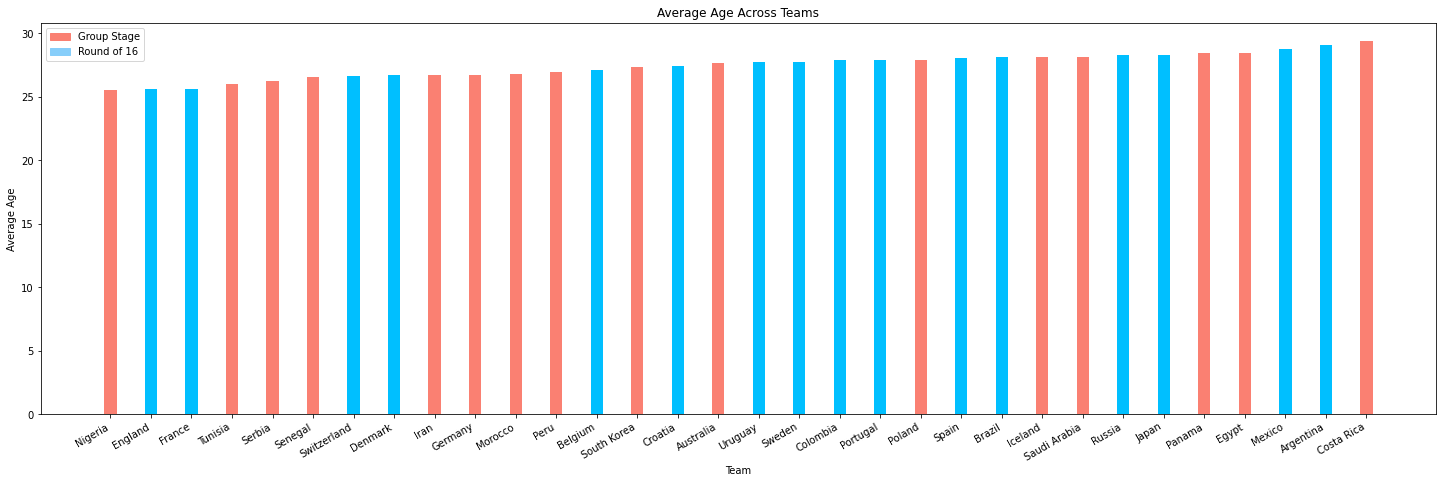

In [19]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Average age of each team
color = [] 
lst_countries = players_2018["country"].unique() # Country in 2018 World Cup

for c in lst_countries: # Go through each team in the 2018 World Cup and calculate the mean age for each team
  x_axis.append(c)
  y_axis.append(players_2018[players_2018["country"] == c]["age"].mean())
  
  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")
  
fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Create the legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x= x_axis,
      y= y_axis,
      c = color 
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar graph


plt.xlabel("Team")
plt.ylabel("Average Age")
plt.title("Average Age Across Teams")
fig.autofmt_xdate()
plt.show()


Not exactly seeing any patterns in particular. Essentially, we would want to see clustering of blue on one side and red on the other side. Ideally, we would have thought that older teams would make it farther into the tournament because they would have more experienced players. This however is not the case. Let's see if the age of the outfield players (all players excluding goalkeepers) changes anything. This is because goalkeepers tend to have higher ages. Just looking at Egypt, they have a goalkeeper at the age of 45 which will skew the mean a lot.

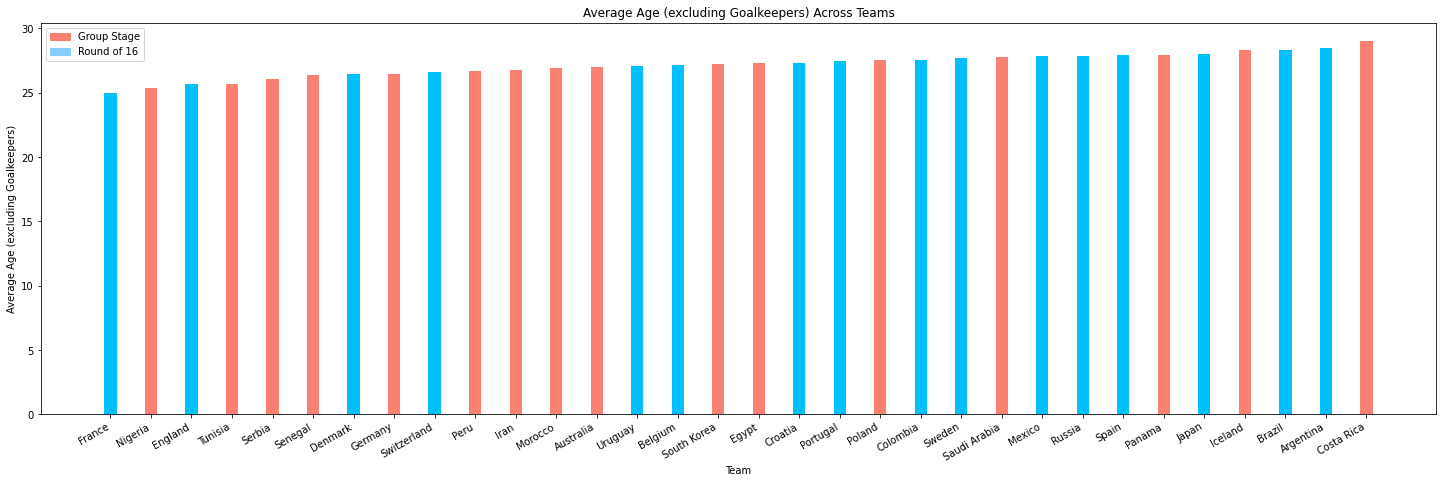

In [20]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Average age of each team excluding goalkeepers
color = []

for c in lst_countries: # Go through each team in the 2018 World Cup and calculate the mean age (excluding goalkeepers) for each team
  x_axis.append(c)
  y_axis.append(players_2018[(players_2018["country"] == c) & (players_2018["position"] != "GK")]["age"].mean())
  
  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")


fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c = color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), width = 0.3, color = "c") # Bar Graph

plt.xlabel("Team")
plt.ylabel("Average Age (excluding Goalkeepers)")
plt.title("Average Age (excluding Goalkeepers) Across Teams")
fig.autofmt_xdate()
plt.show()

Similar results as above with no particular patterns standing out. Just some quick observations, we see that despite France having the youngest outfield squad, they also won the 2018 World Cup. England also have the 3rd youngest outfield squad and made it to the Semi-finals. It doesn't really look like age is a major factor that makes a team progress further into the World Cup. Instead of looking at age, we can look at caps. In football terms, a cap is how many times a player has played for their country in international matches. This should be more informative than age because typically players with higher caps have more experience at the international level.

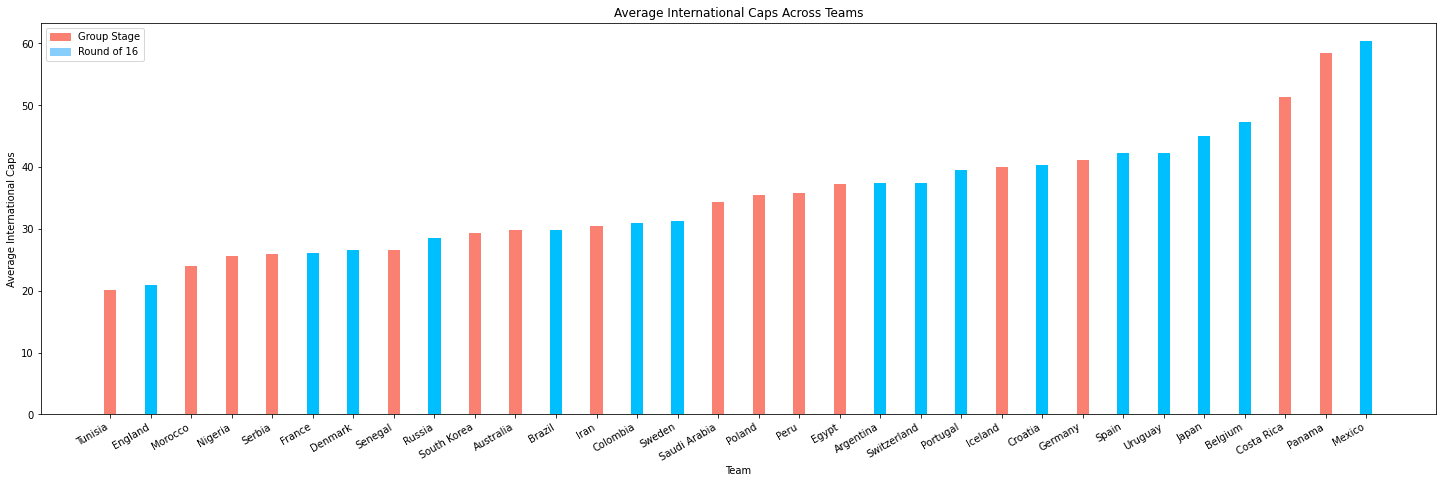

In [21]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Average caps for each team
color = []

for c in lst_countries: # Go through each team in the 2018 World Cup and calculate the mean caps for each team
  x_axis.append(c)
  y_axis.append(players_2018[(players_2018["country"] == c)]["caps"].mean())
  
  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c=color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar Graph

plt.xlabel("Team")
plt.ylabel("Average International Caps")
plt.title("Average International Caps Across Teams")
fig.autofmt_xdate()
plt.show()

Much more variation along the y-axis than compared with age. Like with age, there are no distinct patterns that stand out. Some quick observations however show that Mexico and Panama have more experience on the international stage than other countries. Next, we will make a scatter plot where the x-axis is the average age of the squad, and the y-axis is the average number of caps of the squad.

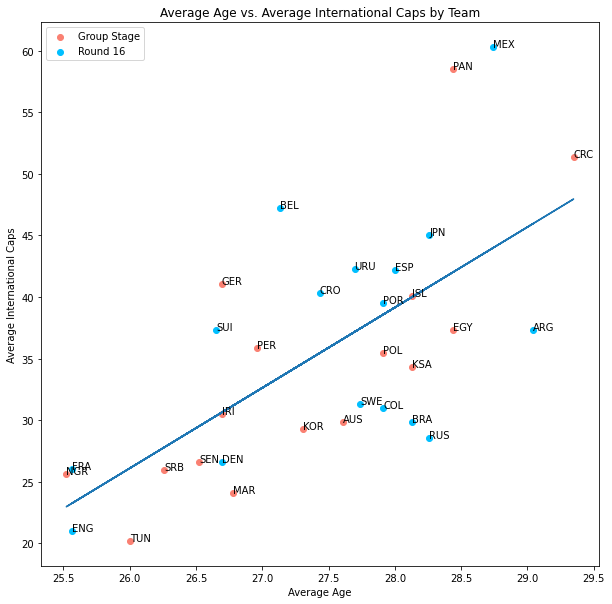

In [22]:
x_axisgroup = [] # Contains the average ages of teams that got eliminated in the group stage
y_axisgroup = [] # Contains the average caps of teams that got eliminated in the group stage
x_axis16 = [] # Contains the average ages of teams that made it to the round of 16 
y_axis16 = [] # Contains the average caps of teams that made it to the round of 16
country_group = [] # Names of countries that got eliminated in the group stage
country_16 = [] # Names of countries that made it to the round of 16

# Go through each team in the tournament and checks to see whether they made it to the round of 16 or not.
# Also calculates the mean ages and caps of each team
for c in lst_countries:
  if c in round16:
    x_axis16.append(players_2018[(players_2018["country"] == c)]["age"].mean())
    y_axis16.append(players_2018[(players_2018["country"] == c)]["caps"].mean())
    country_16.append(c)
  else:
    x_axisgroup.append(players_2018[(players_2018["country"] == c)]["age"].mean())
    y_axisgroup.append(players_2018[(players_2018["country"] == c)]["caps"].mean())
    country_group.append(c)

fig= plt.figure(figsize = (10, 10)) # Change size of plot

x_axis = x_axisgroup + x_axis16 # To create linear regression line
y_axis = y_axisgroup + y_axis16 # To create linear regression line

plt.scatter(x_axisgroup, y_axisgroup, label = "Group Stage", color = "salmon") # Add the teams that got eliminated in the group stage
plt.scatter(x_axis16, y_axis16, label = "Round 16", color = "deepskyblue") # Add the teams that made it to the round of 16

plt.legend(loc = "upper left") # Put legend in upper left corner

m, b = np.polyfit(x = x_axis, y = y_axis, deg = 1) # Find the slope and y-intercept of the linear regression line
plt.plot(x_axis, m*np.array(x_axis) + b) # Plot linear regression line

# Add teams names to each point in the scatter plot
for i, label in enumerate(country_16):
  plt.text(x_axis16[i], y_axis16[i],country_codes[label])
for i, label in enumerate(country_group):
  plt.text(x_axisgroup[i], y_axisgroup[i],country_codes[label])


plt.xlabel("Average Age")
plt.ylabel("Average International Caps")
plt.title("Average Age vs. Average International Caps by Team")
plt.show()

A linear regression line was added which shows there is a correlation between age and caps. This makes sense because the older a player is, the more opportunities they had to play for their country. From this scatter plot, no particular patterns stand out. All the teams seem randomly spread out. Next, we will take a look at how many international goals on average were scored by each team. Typically the teams who win more score more goals and concede less goals. We don't have any data on goals conceded so we will look at international goals scored by each player to see which teams have a better offense.

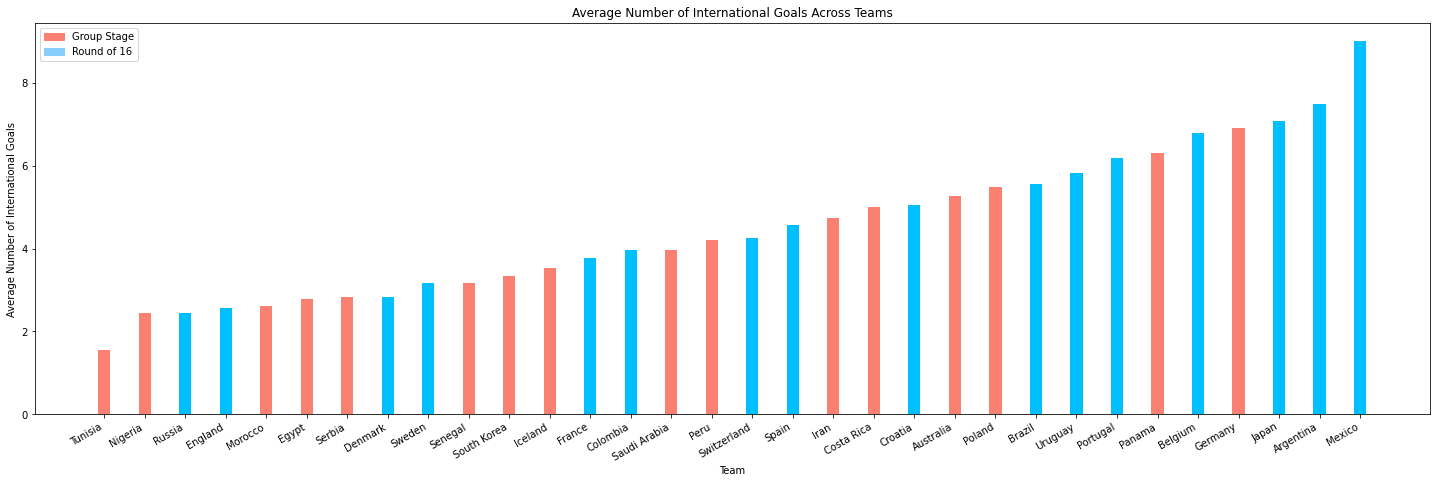

In [23]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Average international goals for each team
color = []

for c in lst_countries: # Go through each team in the 2018 World Cup and calculate the mean number of international goals for each team
  x_axis.append(c)
  y_axis.append(players_2018[(players_2018["country"] == c)]["goals"].mean())

  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c = color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar graph

plt.xlabel("Team")
plt.ylabel("Average Number of International Goals")
plt.title("Average Number of International Goals Across Teams")
fig.autofmt_xdate()
plt.show()

A lot of variance in the y-axis like seen with international caps but no particular patterns stand out. We see that Mexico scores a lot of international goals on average while Tunisia scores the least international goals on average. France (the winners of the last World Cup) is somewhere in the middle with everyone else. Mexico has the highest average caps and highest average number of international goals per player which I found interesting. Typically better players have a higher goal/appearance ratio so let's next take a look at which teams have the best average international goals per cap ratio.

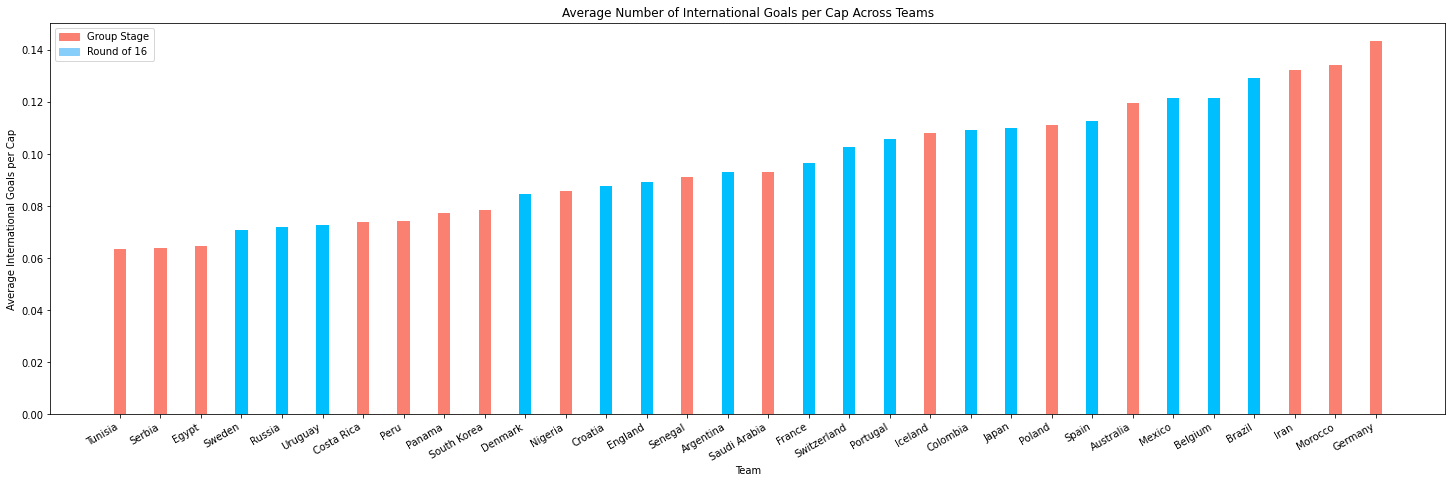

In [24]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Average international goals per cap ratio for each team
color = []

for c in lst_countries: # Go through each team in the 2018 World Cup and calculate the mean international goals per cap ratio for each team
  x_axis.append(c)

  team = players_2018[(players_2018["country"] == c)]
  sum = 0
  for idx, row in team.iterrows(): # Calculate the international goal/cap ratio for each player in a particular team
    if row["caps"] != 0:
      sum += (row["goals"] / row["caps"])
  
  y_axis.append(sum / len(team))
  
  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c = color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar graph

plt.xlabel("Team")
plt.ylabel("Average International Goals per Cap")
plt.title("Average Number of International Goals per Cap Across Teams")
fig.autofmt_xdate()
plt.show()

Like before, no distinct patterns stand out in particular for this graph. Since this took into account positions such as goalkeepers who typically don't score, let's just look at the international goals per cap ratio of the top 5 highest scorers in each squad. Maybe we will start to see patterns with this graph.

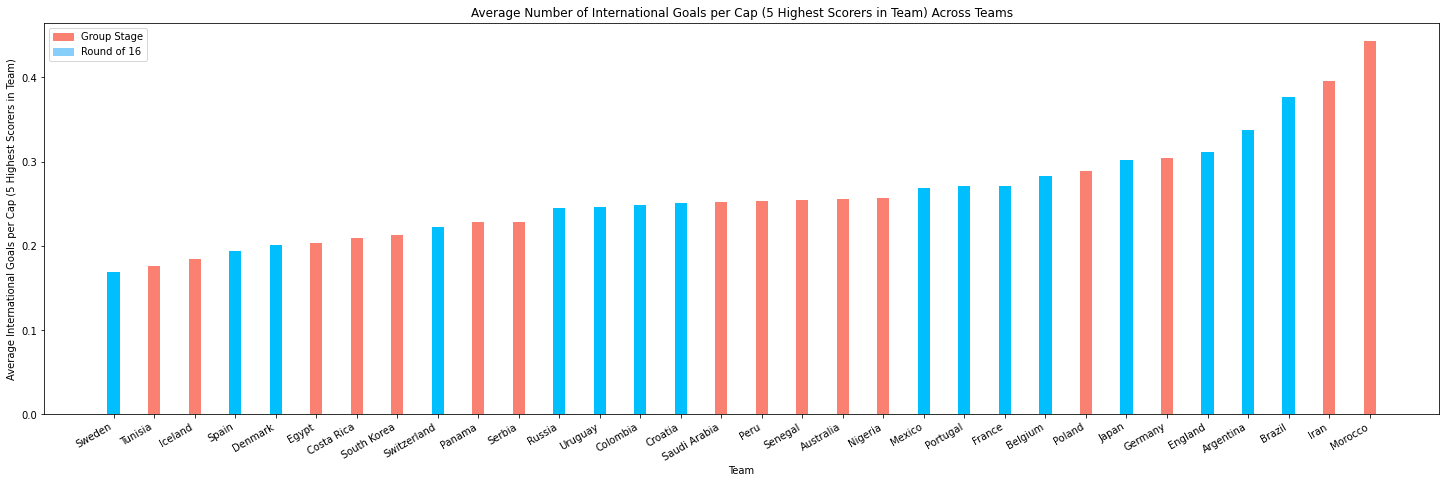

In [25]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Average international goals per cap ratio of 5 highest scorers for each team
color = []


for c in lst_countries: # Calculate the mean international goal/cap ratio for 5 highest scorers for each team
  x_axis.append(c)
  team = players_2018[(players_2018["country"] == c)].sort_values(by= "goals", ascending=False) # Sort the team by amount of goals scored
  sum = 0
  ctr = 0
  for idx, row in team.iterrows(): # Calculate international goal/cap ratio for 5 highest scorers for a particular team
    if row["caps"] != 0:
      sum += (row["goals"] / row["caps"])
      ctr += 1
      if ctr == 5:
        break;
  
  y_axis.append(sum / 5)

  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)
    
# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c = color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar graph

plt.xlabel("Team")
plt.ylabel("Average International Goals per Cap (5 Highest Scorers in Team)")
plt.title("Average Number of International Goals per Cap (5 Highest Scorers in Team) Across Teams")
fig.autofmt_xdate()
plt.show()

Once again, no distinct patterns. Some observations are that Germany is significantly lower than before while Iran and Morocco still have very high international goal per cap ratios even among their top 5 scorers. We have analyzed the statistics of players at the international level but let's analyze them based on their club statistics. For this, I used data from the FIFA game (more info [here](https://en.wikipedia.org/wiki/FIFA_(video_game_series) \) which creates statistics for each player. This data is contained in the dataframe that contains all the player statistics from 2018. The 2 main stats I used from this dataset are the overall player rating and their value. Let's look at the average overall player rating of each team. Overall player rating is just a score given to each player after taking into account different factors such as passing, speed, defending, and so on. 

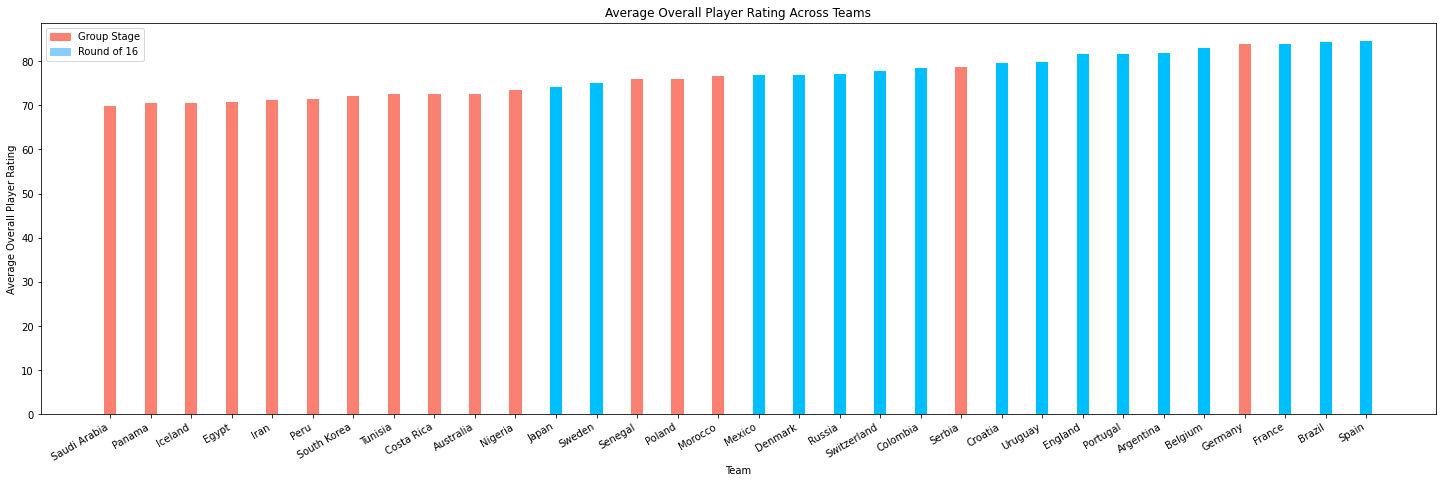

In [26]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Average overall rating of players for each team
color = []

for c in lst_countries: # Calculate the average overall rating for each team
  x_axis.append(c)
  y_axis.append(players_2018[(players_2018["country"] == c)]["Overall"].mean())

  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c = color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar graph

plt.xlabel("Team")
plt.ylabel("Average Overall Player Rating")
plt.title("Average Overall Player Rating Across Teams")
fig.autofmt_xdate()
plt.show()

We finally see a pattern in the data. We see that more teams with a higher average overall player rating made it to the round of 16 while more teams with lower average overall player ratings got eliminated in the group stages. I expected there to be more variance between the team with the lowest overall player rating and the team with the highest overall player rating. Let's look at the average value of players across teams to see if there is a larger gap between the teams (Note: the player value is simply how much money a player is worth). 

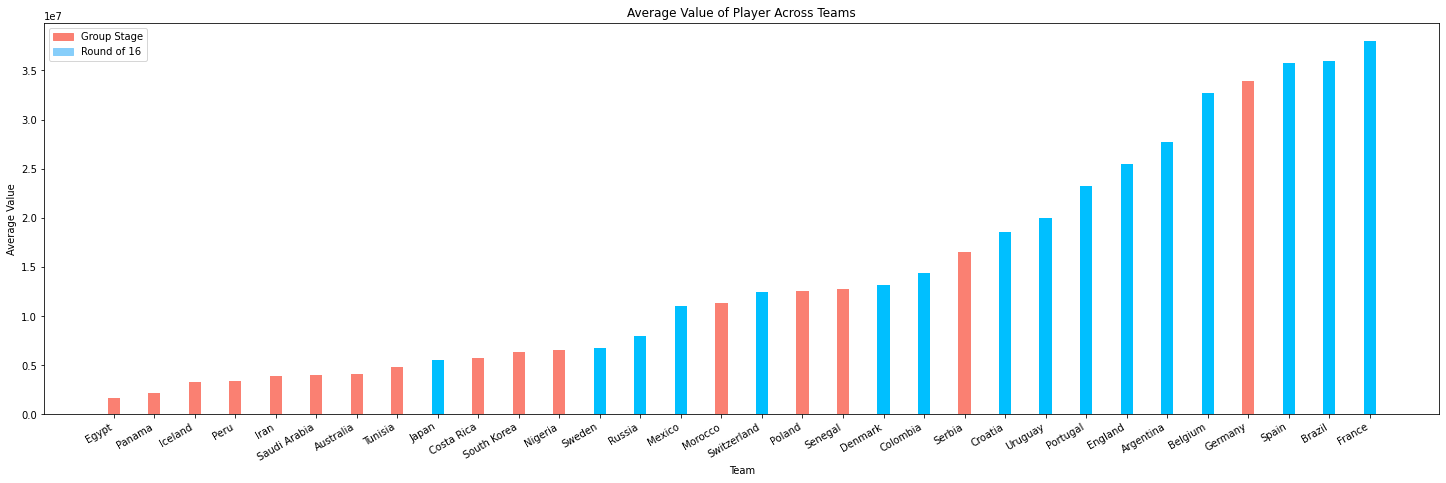

In [27]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Average value of players for each team
color = []

for c in lst_countries: # Calculate the average value of players for each team
  x_axis.append(c)
  y_axis.append(players_2018[(players_2018["country"] == c)]["Value"].mean())

  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add Legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c = color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar Graph

plt.xlabel("Team")
plt.ylabel("Average Value")
plt.title("Average Value of Player Across Teams")
fig.autofmt_xdate()
plt.show()

Now we finally have some data that shows has a pattern. We see that teams that made it into the round of 16 tend to have significantly higher average value of players compared with those who got eliminated in the group stage. We see that teams that have [strong domestic football leagues](https://sportzpoint.com/football/10-most-valuable-football-leagues-in-the-world/) and/or have [previously won World Cups](https://en.wikipedia.org/wiki/List_of_FIFA_World_Cup_finals) before also have players that have higher value. This makes sense because the more popular a sport is in a country, the more likely it will produce athletes that are better in that sport. We see that France, Spain, Brazil, Germany, and Belgium all have very high averages. Of these 5 teams, 4 of them have won World Cups before. These 5 teams are closely followed by Argentina, England, and Portugal where 2 of these teams have previously won World Cups before. It now looks like the more valued players who represent their country at the World Cup come from countries with either strong domestic leagues or are previous World Cup winners. We will check the averages between the teams eliminated in the group stage and teams that made it to the round of 16 to see if there is a significant difference between the 2 means. First let's look at the 2 means between the 2 groups.

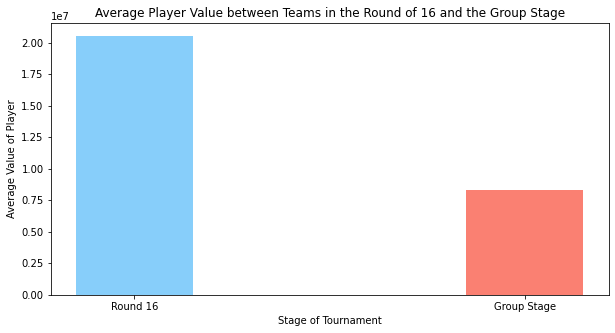

In [28]:
x1 = [] # Average value of players in the round of 16
x2 = [] # Average value of players who got eliminated in the group stage

for idx, row in players_2018.iterrows(): # Goes through every player participating in the 2018 World Cup and see at what stage they made it to
  if row["country"] in round16:
    x1.append(row["Value"])
  else:
    x2.append(row["Value"])

fig= plt.figure(figsize = (10, 5)) # Change size of plot

x = math.fsum(x1) / len(x1) # Calculate the average value of players in the round of 16
y = math.fsum(x2) / len(x2) # Calculate the average value of players that got eliminated in the group stage

plt.bar(["Round 16", "Group Stage"], [x, y], color = ["lightskyblue", "salmon"], width = 0.3) # Bar graph
plt.xlabel("Stage of Tournament")
plt.ylabel("Average Value of Player")
plt.title("Average Player Value between Teams in the Round of 16 and the Group Stage")

plt.show()

As you can see the average value of the teams that made it to the round of 16 have a much higher value than the teams that got eliminated in the group stage. Let's run a 2-sample t-test to see if there is a significant difference between the 2 populations.

In [29]:
print(stats.ttest_ind(a=x1, b=x2, equal_var=True))

Ttest_indResult(statistic=10.01637260068785, pvalue=3.1958179263080343e-22)


After running the 2-sample t-test, we see the p-value is 3.1958179263080343e-22 which is less than .05 meaning that the average value of players between these 2 populations are significantly different.
We can next see how many players from each country play in the top 50 clubs in the world. This should show similar results as the graph with the average player value per team.

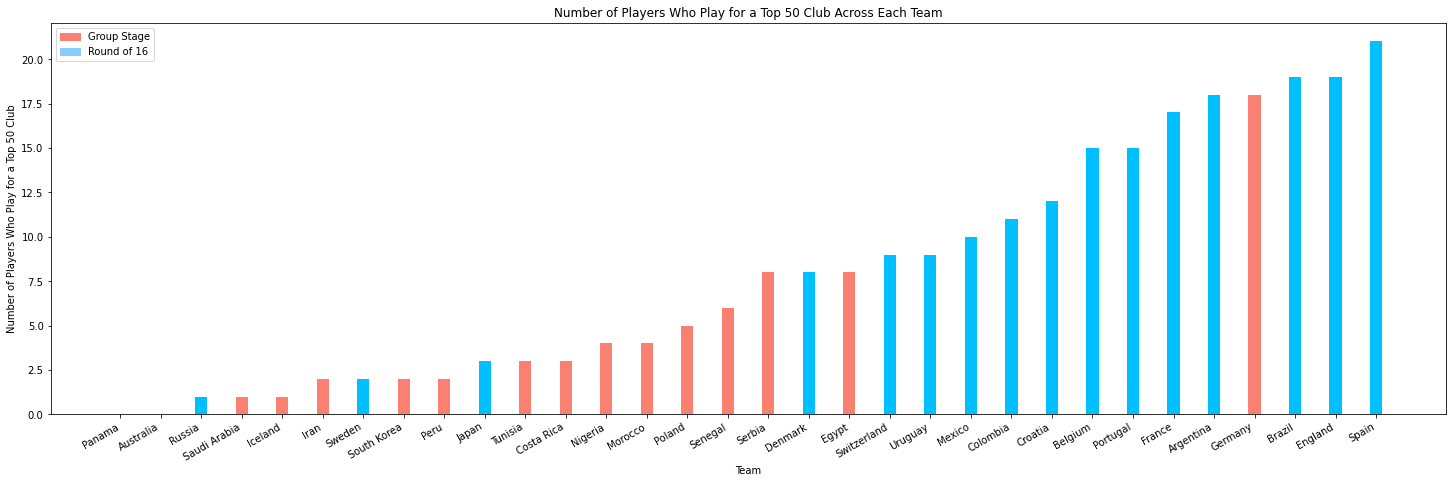

In [30]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Number of players who play for a top 50 club
color = []

clubs50 = top_50_clubs["club_name"].astype(str).values.tolist() # Gets list of top 50 clubs in the world

for c in lst_countries: # Go through each team and counts how many players in the team plays for a top 50 club
  x_axis.append(c)
  
  team = players_2018[(players_2018["country"] == c)]
  ctr = 0
  for idx, row in team.iterrows():
    s = str(row["club"])
    if s in clubs50:
      ctr += 1
  
  y_axis.append(ctr)

  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c = color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar graph

plt.xlabel("Team")
plt.ylabel("Number of Players Who Play for a Top 50 Club")
plt.title("Number of Players Who Play for a Top 50 Club Across Each Team")
fig.autofmt_xdate()
plt.show()

Like above, we see a trend where teams that made it to the round of 16 tend to have players that play for better clubs when compared to the teams that got eliminated in the group stage. Let's see what happens if we cut the number of clubs down to 20.

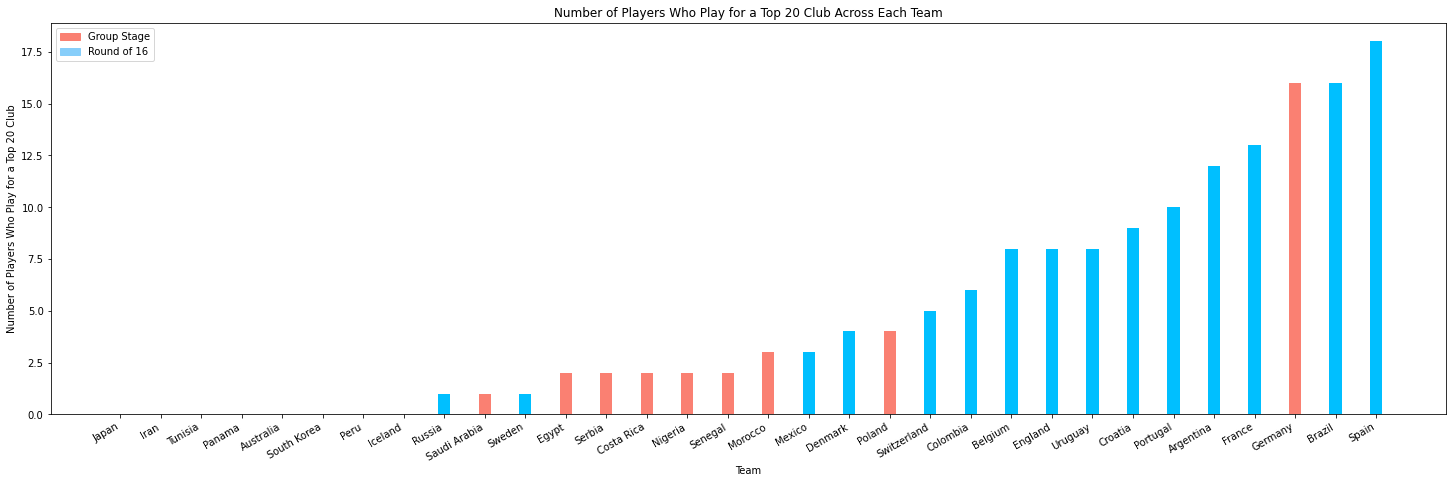

In [31]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Number of players who play for a top 20 club
color = []
clubs20 = clubs50[:20] # Get the top 20 clubs in the world

for c in lst_countries: # Go through each team and counts how many players in the team plays for a top 20 club
  x_axis.append(c)

  team = players_2018[(players_2018["country"] == c)]
  ctr = 0
  for idx, row in team.iterrows():
    s = str(row["club"])
    
    if s in clubs20:
      ctr += 1
  
  y_axis.append(ctr)

  # Assign color to team based on how far they made it in the tournament
  if c in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c=color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar graph

plt.xlabel("Team")
plt.ylabel("Number of Players Who Play for a Top 20 Club")
plt.title("Number of Players Who Play for a Top 20 Club Across Each Team")
fig.autofmt_xdate()
plt.show()

Same conclusion as before, the teams that that made it further in the tournament have more players that play for better clubs. Since we have been looking at individual stats from each team, we should now look at how each team did overall in the tournament by comparing their actual results with each other. I am first going to look at the average amount of goals scored by each country per game in the 2018 World Cup vs. the average value of each team. I am going to only look at the average value of the attacking players of the team because they are the ones that typically score the goals.
 

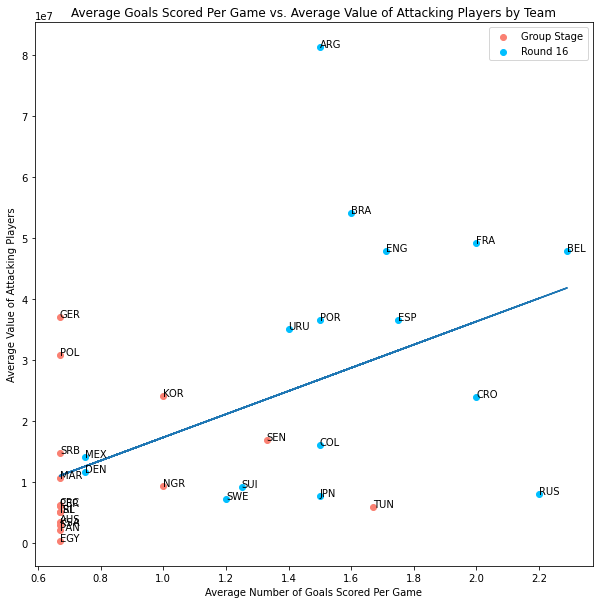

In [32]:
x_axisgroup = [] # Contains the average goals scored per game of teams that got eliminated in the group stage
y_axisgroup = [] # Contains the average attacking player value of teams that got eliminated in the group stage
x_axis16 = [] # Contains the average goals scored per game of teams that made it to the round of 16 
y_axis16 = [] # Contains the average attacking player value of teams that made it to the round of 16
country_group = [] # Names of countries that got eliminated in the group stage
country_16 = [] # Names of countries that made it to the round of 16

# Go through each team in the tournament and checks to see whether they made it to the round of 16 or not.
# Also calculates average attacking player value for each team
for c in lst_countries: 
  if c in round16:
    x_axis16.append(teams_2018[teams_2018["Team"] == c]["AGF"].sum())
    y_axis16.append(players_2018[(players_2018["country"] == c) & (players_2018["position"] == "FW")]["Value"].mean())
    country_16.append(c)
  else:
    x_axisgroup.append(teams_2018[teams_2018["Team"] == c]["AGF"].sum())
    y_axisgroup.append(players_2018[(players_2018["country"] == c) & (players_2018["position"] == "FW")]["Value"].mean())
    country_group.append(c)

fig= plt.figure(figsize = (10, 10)) # Change size of plot

x_axis = x_axisgroup + x_axis16 # To create linear regression line
y_axis = y_axisgroup + y_axis16 # To create linear regression line

plt.scatter(x_axisgroup, y_axisgroup, label = "Group Stage", color = "salmon") # Add the teams that got eliminated in the group stage
plt.scatter(x_axis16, y_axis16, label = "Round 16", color = "deepskyblue") # Add the teams that made it to the round of 16

plt.legend(loc = "upper right") # Put legend in upper right hand corner

m, b = np.polyfit(x = x_axis, y = y_axis, deg = 1) # Find the slope and y-intercept of the linear regression line
plt.plot(x_axis, m*np.array(x_axis) + b) # Plot linear regression line

# Add teams names to each point in the scatter plot
for i, label in enumerate(country_16):
  plt.text(x_axis16[i], y_axis16[i],country_codes[label])
for i, label in enumerate(country_group):
  plt.text(x_axisgroup[i], y_axisgroup[i],country_codes[label])


plt.xlabel("Average Number of Goals Scored Per Game")
plt.ylabel("Average Value of Attacking Players")
plt.title("Average Goals Scored Per Game vs. Average Value of Attacking Players by Team")
plt.show()

From the following graph, we see that the teams that made it to the round of 16 typically scored more goals per game than the teams that got eliminated in the group stages. From the graph, we see that Russia and Croatia definitely scored more goals per game than expected when looking at the average value of their attacking players. In the 2018 World Cup, Croatia made it all the way to the finals where they lost to France and Russia made it to the quarter-finals. France and Croatia scored on average the same amount of goals per game despite the average player value for France being significantly higher. Argentina had the significantly highest average value of their attacking players but did poor in terms of average goals per game scored. For football clubs seeking to add players to their teams, Croatian and Russian attack players would be a good investment. Next, let's look at average goals per game conceded vs. average player values for the defense. For the defense I am including the defensive players and the goalkeepers.    

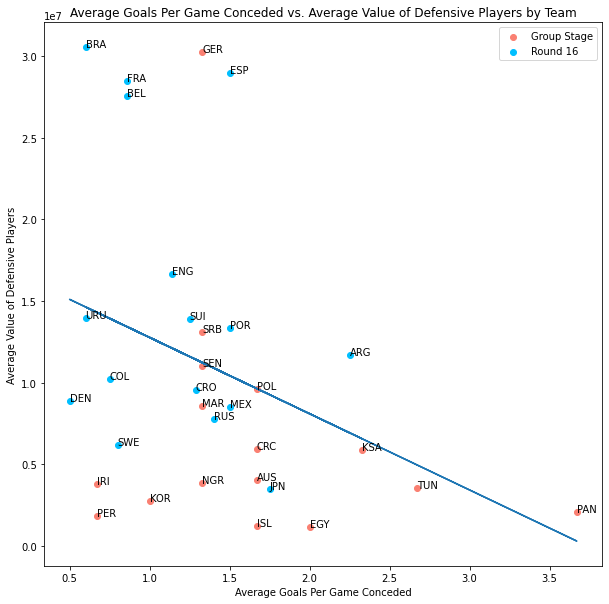

In [33]:
x_axisgroup = [] # Contains the average goals conceded per game of teams that got eliminated in the group stage
y_axisgroup = [] # Contains the average defending player value of teams that got eliminated in the group stage
x_axis16 = [] # Contains the average goals conceded per game of teams that made it to the round of 16 
y_axis16 = [] # Contains the average defending player value of teams that made it to the round of 16
country_group = [] # Names of countries that got eliminated in the group stage
country_16 = [] # Names of countries that made it to the round of 16

# Go through each team in the tournament and checks to see whether they made it to the round of 16 or not.
# Also calculates average defending player value for each team
for c in lst_countries:
  if c in round16:
    x_axis16.append(teams_2018[teams_2018["Team"] == c]["AGA"].sum())
    y_axis16.append(players_2018[(players_2018["country"] == c) & ((players_2018["position"] == "GK") | (players_2018["position"] == "DF"))]["Value"].mean())
    country_16.append(c)
  else:
    x_axisgroup.append(teams_2018[teams_2018["Team"] == c]["AGA"].sum())
    y_axisgroup.append(players_2018[(players_2018["country"] == c) & ((players_2018["position"] == "GK") | (players_2018["position"] == "DF"))]["Value"].mean())
    country_group.append(c)

fig= plt.figure(figsize = (10, 10)) # Change size of plot

x_axis = x_axisgroup + x_axis16 # To create linear regression line
y_axis = y_axisgroup + y_axis16 # To create linear regression line

plt.scatter(x_axisgroup, y_axisgroup, label = "Group Stage", color = "salmon") # Add the teams that got eliminated in the group stage
plt.scatter(x_axis16, y_axis16, label = "Round 16", color = "deepskyblue") # Add the teams that made it to the round of 16

plt.legend(loc = "upper right") # Put legend in upper right hand corner

m, b = np.polyfit(x = x_axis, y = y_axis, deg = 1) # Find the slope and y-intercept of the linear regression line
plt.plot(x_axis, m*np.array(x_axis) + b) # Plot linear regression line

# Add teams names to each point in the scatter plot
for i, label in enumerate(country_16):
  plt.text(x_axis16[i], y_axis16[i],country_codes[label])
for i, label in enumerate(country_group):
  plt.text(x_axisgroup[i], y_axisgroup[i],country_codes[label])


plt.xlabel("Average Goals Per Game Conceded")
plt.ylabel("Average Value of Defensive Players")
plt.title("Average Goals Per Game Conceded vs. Average Value of Defensive Players by Team")
plt.show()

Based off the results, it looks like teams that made it to the round of 16 and teams that got eliminated in the group stage concede the same amount of goals per game. There is a cluster of 5 countries (Brazil, France, Germany, Belgium, and Spain) that have significantly higher average value defense than everyone else. However, there were a lot of teams that had much lower average values for defensive players that didn't concede a lot of goals. This graph shows that it is easier to defend goals rather than scoring them. Let's now look at the average goals conceded per game and average goals scored per game for each team. The ideal team should have a high average goals scored and low average goals conceded.

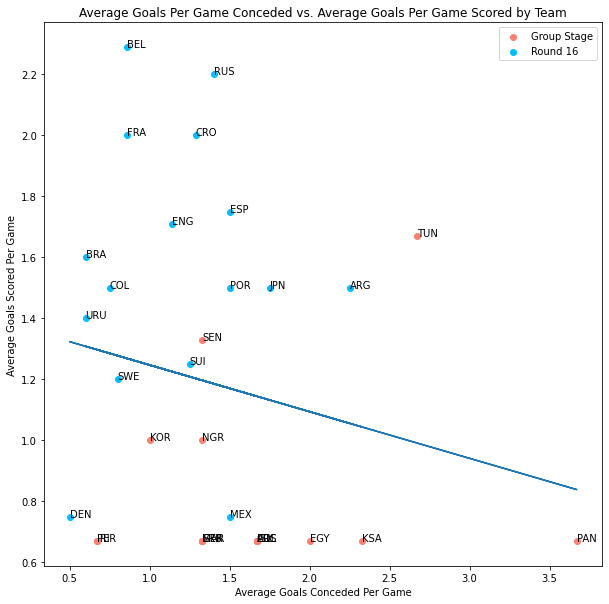

In [34]:
x_axisgroup = [] # Contains the average goals conceded per game of teams that got eliminated in the group stage
y_axisgroup = [] # Contains the average goals scored per game of teams that got eliminated in the group stage
x_axis16 = [] # Contains the average goals conceded per game of teams that made it to the round of 16 
y_axis16 = [] # Contains the average goals scored per game of teams that made it to the round of 16
country_group = [] # Names of countries that got eliminated in the group stage
country_16 = [] # Names of countries that made it to the round of 16

# Go through each team in the tournament and checks to see whether they made it to the round of 16 or not
for c in lst_countries:
  if c in round16:
    x_axis16.append(teams_2018[teams_2018["Team"] == c]["AGA"].sum())
    y_axis16.append(teams_2018[teams_2018["Team"] == c]["AGF"].sum())
    country_16.append(c)
  else:
    x_axisgroup.append(teams_2018[teams_2018["Team"] == c]["AGA"].sum())
    y_axisgroup.append(teams_2018[teams_2018["Team"] == c]["AGF"].sum())
    country_group.append(c)

fig= plt.figure(figsize = (10, 10)) # Change size of plot

x_axis = x_axisgroup + x_axis16 # To create linear regression line
y_axis = y_axisgroup + y_axis16 # To create linear regression line

plt.scatter(x_axisgroup, y_axisgroup, label = "Group Stage", color = "salmon") # Add the teams that got eliminated in the group stage
plt.scatter(x_axis16, y_axis16, label = "Round 16", color = "deepskyblue") # Add the teams that made it to the round of 16

plt.legend(loc = "upper right") # Put legend in upper right hand corner

m, b = np.polyfit(x = x_axis, y = y_axis, deg = 1) # Find the slope and y-intercept of the linear regression line
plt.plot(x_axis, m*np.array(x_axis) + b) # Plot linear regression line

# Add teams names to each point in the scatter plot
for i, label in enumerate(country_16):
  plt.text(x_axis16[i], y_axis16[i],country_codes[label])
for i, label in enumerate(country_group):
  plt.text(x_axisgroup[i], y_axisgroup[i],country_codes[label])


plt.xlabel("Average Goals Conceded Per Game")
plt.ylabel("Average Goals Scored Per Game")
plt.title("Average Goals Per Game Conceded vs. Average Goals Per Game Scored by Team")
plt.show()

Based off this graph, we can see that the teams that made it to the round of 16 tend to score more goals per game on average when compared to teams that got eliminated in the group stage. In terms of average goals per game conceded, there doesn't really seem like there is a big difference between the teams that made it to the round of 16 and the teams that got eliminated in the group stage. 

# Linear Regression 

After analyzing the previous graphs and making some general observations, we can now see that the teams that advanced to the round of 16 compared to teams that got eliminated in the group stage tend to have players that have more value (in both defense and offense), play for better clubs, and score more goals per game (in the tournament). We can apply what we learned from the patterns in the data to predict something such as the probability of a team making it to the round of 16. We can now create a linear regression model with these factors as multiple independent variables. The dependent variable in this case will be the probability of making it to the round of 16. I went and calculated how many times a team made it to the round of 16 divided by the amount of times a team participated in a World Cup. Since the round of 16 format was only introduced in 1986, for World Cups before this one, I grouped the first round of the tournament as being eliminated in the group stage and the second stage of the tournament as making it to the round of 16. The group stage is synonymous with getting eliminated in the first round of the tournament while the second round of the tournament is synonymous with making it to the round of 16. In the next cell you will see that I used OLS which creates a table with coefficients for each independent variable in the linear regression model.

In [35]:
import statsmodels.formula.api as smf


full_df = pd.DataFrame(teams_2018[["Team", "AGF", "AGA", "second_round"]]) # Get the columns that will be used in the linear regression model
full_df = full_df.drop(32) # Remove the last row of the dataframe

full_df["top50club"] = 0 # Create new column that will contain the number of players in each team who play for a top 50 club
full_df["AVG_DEF_VAL"] = 0 # Create new column that will contain the average value of defensive players for a specific team
full_df["AVG_OFF_VAL"] = 0 # Create new column that will contain the average value of offensive players for a specific team




clubs50 = top_50_clubs["club_name"].astype(str).values.tolist() # Gets list of top 50 clubs in the world

for idx, row in full_df.iterrows(): # Goes through each team in the dataframe and calculates the the respective values
  full_df.at[idx, "AVG_OFF_VAL"] = float(players_2018[(players_2018["country"] == row["Team"]) & (players_2018["position"] == "FW")]["Value"].mean()) # Calculate the average value of offensive players for a specific team
  full_df.at[idx, "AVG_DEF_VAL"] = float(players_2018[(players_2018["country"] == row["Team"]) & ((players_2018["position"] == "GK") | (players_2018["position"] == "DF"))]["Value"].mean()) # Calculate the average value of defensive players for a specific team
  
  # Calculates the number of players who play for top 50 clubs for a specific team
  team = players_2018[(players_2018["country"] == row["Team"])]
  ctr = 0
  for i, row in team.iterrows():
    s = str(row["club"])
    if s in clubs50:
      ctr += 1
  full_df.at[idx, "top50club"] = ctr


table = smf.ols("second_round ~ AGF + top50club + AVG_DEF_VAL + AVG_OFF_VAL", data=full_df).fit() # Create linear regression model

print(table.summary())

                            OLS Regression Results                            
Dep. Variable:           second_round   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     5.672
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00190
Time:                        00:10:37   Log-Likelihood:                 6.3413
No. Observations:                  32   AIC:                            -2.683
Df Residuals:                      27   BIC:                             4.646
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2201      0.096      2.300      

Using the coefficients we have obtained from the linear regression model, we can see the probability of a team making it into the round of 16 for the 2018 World Cup.

In [36]:
for idx, row in full_df.iterrows():
  win = table.params["Intercept"] + (table.params["AGF"] * row["AGF"]) + (table.params["top50club"] * row["top50club"]) + (table.params["AVG_DEF_VAL"] * row["AVG_DEF_VAL"]) + (table.params["AVG_OFF_VAL"] * row["AVG_OFF_VAL"])
  print(row["Team"] + "'s probability of making it to the second round (round of 16): " + str(win))

Argentina's probability of making it to the second round (round of 16): 0.6770723545566274
Australia's probability of making it to the second round (round of 16): 0.2821164281261478
Belgium's probability of making it to the second round (round of 16): 0.7766143730264421
Brazil's probability of making it to the second round (round of 16): 0.8462061437868699
Colombia's probability of making it to the second round (round of 16): 0.4703530988155387
Costa Rica's probability of making it to the second round (round of 16): 0.3319262499510018
Croatia's probability of making it to the second round (round of 16): 0.49243783205232805
Denmark's probability of making it to the second round (round of 16): 0.4148539223220104
Egypt's probability of making it to the second round (round of 16): 0.3007640051843606
England's probability of making it to the second round (round of 16): 0.6735451153894731
France's probability of making it to the second round (round of 16): 0.8015631929605049
Germany's probab

We can plot the previous findings to see if there are any patterns.

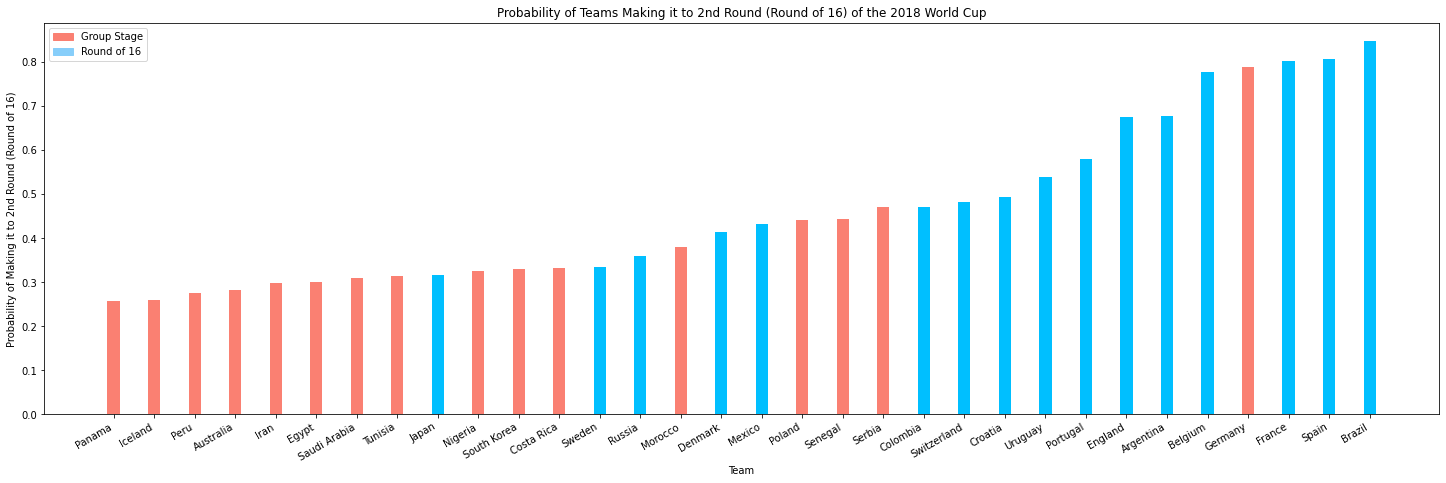

In [37]:
x_axis = [] # Countries in the 2018 World Cup
y_axis = [] # Probability of team making it to the round of 16
color = []

for idx, row in full_df.iterrows(): # Goes through each team in the 2018 World Cup and finds probability of them making it to the round of 16
  x_axis.append(row["Team"])
  y_axis.append(table.params["Intercept"] + (table.params["AGF"] * row["AGF"]) + (table.params["top50club"] * row["top50club"]) + (table.params["AVG_DEF_VAL"] * row["AVG_DEF_VAL"]) + (table.params["AVG_OFF_VAL"] * row["AVG_OFF_VAL"]))

  # Assign color to team based on how far they made it in the tournament
  if row["Team"] in round16:
    color.append("deepskyblue")
  else:
    color.append("salmon")

fig= plt.figure(figsize = (25, 8)) # Change size of plot

# Add legend
# Code from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors_labels = {"Group Stage" : "salmon", "Round of 16": "lightskyblue"}
labels = list(colors_labels.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_labels[label]) for label in labels]
plt.legend(handles, labels)

# Allows the bar graph to be sorted in ascending order
# From https://www.tutorialspoint.com/how-to-sort-bars-in-increasing-order-in-a-bar-chart-in-matplotlib
df = pd.DataFrame(
   dict(
      x=x_axis,
      y=y_axis,
      c = color
   )
)
plt.bar("x", "y", data = df.sort_values("y", ascending=True), color = "c", width = 0.3) # Bar graph

plt.xlabel("Team")
plt.ylabel("Probability of Making it to 2nd Round (Round of 16)")
plt.title("Probability of Teams Making it to 2nd Round (Round of 16) of the 2018 World Cup")
fig.autofmt_xdate()
plt.show()

We can see from this graph that of the 16 teams with the highest probabilities of making it to the round of 16, 12 of them actually made it. For a very basic linear regression model, it didn't do that bad in predicting whether a team would make it into the round of 16 or not.

# Conclusion

The linear regression may have not been the best model to run on the given data since it is not very linear in nature, but this is a stepping stone to more complicated and accurate models that can be used using these factors.

While we only looked at a fraction of the factors that go into a team being successful in the World Cup, there are many other factors that we could look at like team chemistry, clean sheets (not letting any goals in), player's club playing time, the players that actually played during the games, etc. These initial factors can be a starting point in order to predict things such as who the winner of the tournament will be, which team will score the most goals, etc. 

By doing this data analysis on the World Cup 2018 data, you could be able to identify factors of the successful teams and use these as variables to create a machine learning model that could then tell you things such as win probabilities between 2 teams. If we performed this data analysis on every single World Cup starting from 1930, we could have enough data to train and test a logistic model which can have further uses such as predicting the winner for this year's World Cup. This is only 1 real life application that this data and machine learning model can have. 

While we try to quantify sports and try to predict winners, we still have to remember that numbers can't always predict everything. Just look at Germany. In 2014 they won the World Cup and in 2018, they got eliminated in the group stage (first round) despite being one of the favorites to win. Sometimes numbers can't explain everything and it's just best to enjoy the moment. 